# Exploring Python's *SimPy* as a Simulation Tool

## Vivek Gawande & Sameer Vinayak

### Abstract

### Background & Overview

SimPy is a python module that supports the creation of process-interaction-based simulation models. The module was first developed in 2002, and is now on version 4.0.1. While primarily developed in python, ports of the module exist for the C#, Julia, and R languages. Unlike standalone software such as Arena, SimPy is used as an addition to the existing python language, meaning a user of SimPy must be relatively familiar with python. On the same note, however, a user of python may have an easier type getting accustomed to the simulation framework once educated on some of the terminology. 

The module relies heavily on python's generator object in order to facilitate the concept of "waiting". This "waiting" is used to allow for processes to finish and for resources to become available. This allows the module to offer functionality analogous to an asynchronous event dispatcher. In other words, multiple processes can be running in parallel, and these processes can trigger other processes that are due next.

Similar to other simulation software like Arena, SimPy has basic objects that are used to facilitate simulations. For example, *processes* are events that take place, such as entering a store and shopping, or repairing a car, to give a few examples. *Resources* are objects that can be relied upon in order to carry out processes, such as a spot at a register to pay or a mechanic to repair a car. A *container* can be used to track fluctuating resources, like the amount of money in a wallet. There are many more object types, and each comes with useful methods with which to interact.

As mentioned, the module takes advantage of being embedded in the python language. Accordingly, functionality such as random variate generation, did not need to be re-implemented for the purpose of this module. Instead, the module allows the user to simply use the built-in modules (such as ```random```) in conjunction with this module. That allows for the user to user already-familiar syntax for common tasks like generating a random number. In a similar vein, SimPy does not appear to offer automatically generated simulation reports. Instead, the creator is expected to use built in data structures such as lists and dictionaries to track the results of the simulation as they are occuring. This allows for a great amount of customization at the expense of up front costs and tediousness.

In the remainder of this project, we will begin by giving a high level User Guide to using SimPy. This will display the fundamental classes that make up the core functionality of the module. Then, we will give two example simulations. This will touch on some of the more advanced concepts of SimPy. Next, we will give our comments and opinions on using the module before concluding.

### User Guide

In order to install SimPy, users can simply use pip by running the following command:
```
pip install simpy
```
This will install the latest release available publicly. The module impressively has no other dependencies and relies solely on core python. Due to the extensive use of generators, python 3 is strongly preferred for use of the package.

The module can then be imported as shown below.

In [1]:
import simpy

First, we will create an environment object, which will house all of the processes and resources that we will use. Any simulation in SimPy must belong to an environment. 

Then, we will create a ```runner``` function to represent an athlete who can either run or hydrate. The key concept used to facilitate this timed switching between activities is ```yield```, which returns a generator. Throughout the process, we can print (or alternatively store) the times at which the action commenced.

In [4]:
env = simpy.Environment()

def runner(env):
    while True:
        print("start running at at %d" % env.now)
        running_time = 10  # runner runs for 10 minutes
        yield env.timeout(running_time)
        
        print("start hydrating at at %d" % env.now)
        hydrating_time = 2  # runner runs for 10 minutes
        yield env.timeout(hydrating_time)

The above function outlines how a runner may behave. Now, we need to execute the process. To do so, we also need to decide when the process will end. In this basic example, we can simply end once the time has reached 60 minutes.

In [5]:
how_long = 60
env.process(runner(env))  # this essentially connects the process to the environment.
                          # multiple processes can be added to an environment.
env.run(until=how_long)

start running at at 0
start hydrating at at 10
start running at at 12
start hydrating at at 22
start running at at 24
start hydrating at at 34
start running at at 36
start hydrating at at 46
start running at at 48
start hydrating at at 58


In the coming example, we will discuss more advanced functionality, such as drawing from a distribution, using resources, and running competing processes. To conclude this high level user guide, we have provided a glossary of key concepts:

- ```Environment``` - the execution space for the simulation. SimPy also supports ```RealTimeEnvironment```, which uses wall-clock time, but the standard Environment is event-based, and the progression of time is determined by the beginning and end of events. An environment can be instantiated with a start time if using 0 is not preferred. Multiple processes can belong to one environment.
- ```yield```/*generator* - these core python concepts are used throughout SimPy simulations in order to simulate the "waiting" process. One must yield a timeout object to ensure the simulation follows the rules that estimate reality.
- ```Environment.timeout()``` - the ```.timeout()``` method returns an event after a specified delay. This can be thought of as Arena's "Seize-Delay-Release" all in one. 
- ```Environment.process()``` - once an environment is created, one should ```process``` (different from the noun process) a generator, which can be returned from a custom-defined object. In our example above, the custom function ```runner``` yields a generator, which gets processed by the environment. In layperson's terms, processing an item adds it to the environment for future use.
- ```Environment.run()``` - this method executes the generators in the environment. The environment runs until either the specified time is met, or there are no further events to be processed. Alternatively, one can pass another event into the "until" parameter, and the simulation will run until that event is processed. 

### Example

Let us build upon the runner example above to illustrate how SimPy can be used to model a scenario that is closer to real-life.

In this example, we configure the model to have multiple runners, who run a set number of laps in a race. Each runner starts with the same amount of energy, which is replenished at a fixed number of water fountains, which can only be used by one runner at a time.

Below, we import numpy's ```normal``` method, which will be used to generate a number from a normal distribution centered around a given mean.

In [63]:
from numpy.random import normal

The environment variables below define the resources and specifications of the simulation.

In [64]:
NUMBER_OF_RUNNERS = 5
NUMBER_OF_WATER_FOUNTAINS = 2
MAX_ENERGY = 15
NUMBER_OF_LAPS = 4

The in-line comments explain what certain lines do, and a full discussion is below the definition of the function.

In [93]:
def runner(env, runner_number, fountain, laps_completed=0, energy_units=MAX_ENERGY, output=True):
    while laps_completed < NUMBER_OF_LAPS:  # stop once the runner finishes the final lap
        
        # first, the runner completes a lap.
        lap_time = int(normal(5))  # generate a number from a normal dist with mean=5
                                   # to represent how long the current lap took to run
        laps_completed += 1
        
        # The number of "energy units" used is equal to
        # the length of the lap plus the lap number
        # this way, each additional lap uses linearly more energy
        energy_units -= (lap_time+laps_completed)
        
        # the yield statement is what actually
        # simulates the time passing/runner running
        yield env.timeout(lap_time)
        
        if output:
            print('Runner {} finished lap #{} in {} minutes. Energy level: {}. Current stopwatch: {}'.format(runner_number, laps_completed,
                                                    lap_time, energy_units, env.now))
        
        # next, the runner goes to the water fountain to replenish
        
        # we make a "request" to the fountain resource, which is
        # created with a capacity NUMBER_OF_WATER_FOUNTAINS
        with fountain.request() as req:
            yield req  # ensures that only up to NUMBER_OF_WATER_FOUNTAINS
                       # people use the resource at once
            
            # reduce the max energy as one tires
            new_max_energy = MAX_ENERGY - laps_completed
            
            # arbitrary example of how one might calculate the water break length
            # alternatively, this can be randomized or drawn from a distribution
            water_break_length = (new_max_energy - energy_units) // 3
            
            # simulate time passing for the water break
            yield env.timeout(water_break_length)  # replenish
            energy_units = new_max_energy # reduce the maximum possible energy
            
            if output:
                print('Runner {} replenished with some water. Energy back to {}. Water break took {} minutes.'.format(runner_number, 
                                                                    energy_units,
                                                                   water_break_length))

    
    if output:
        print("---RUNNER {} COMPLETED THE CIRCUIT IN {} MINUTES!---".format(runner_number, env.now))
    current_finish_times.append(env.now)  # storing the finish time in order to generate reporting
    

The function above models a plausible scenario for how a race might play out - runners all start at the same time at the beginning, run a fixed number of laps, and in between laps, must share a fixed number of water fountain resources to replenish their energy. If a fountain is not available, runners must wait until one becomes available.

In this case, we drew the length of each lap from a normal distribution using numpy's ```random.normal```. This, and many other details about the model outlined in the in-line comments, are implemented using core python simply as variables and rudimentary calculations. This perhaps increase the up front cost compared to using a dedicated user interface, but infinitely increases the flexibility and room for customization.

In order to use a shared resource, we make a request to the resource, which is pre-defined with a capacity. Since a ```with``` statement was used, the resource gets automatically released once that segment of code is completed. Alternatively, we could have manually released the resource using the ```.release()``` method, but in this case there wasn't a need for additional verbosity. Doing so puts the onus on the user to ensure that all resources are released when done being used to avoid holding a resource indefinitely, much like in Arena. SimPy's ```Resource``` is by default FIFO, but the library also offers other resource types, such as ```PriorityResource``` and ```PreemptiveResource```.

We append each runner's finish time to ```current_finish_times```for later use in making statistical conclusions about the race.

To execute the simulation, we set up the environment as before below. A resource is created into the ```fountain``` variable, which has a pre-determined capacity. Then, for each runner, we ```process``` the runner to add them to the environment before running the environment and simulation.

In [94]:
env = simpy.Environment()
fountain = simpy.Resource(env, capacity=NUMBER_OF_WATER_FOUNTAINS)  # create shared resource
for current_runner in range(1, NUMBER_OF_RUNNERS+1):  # add each runner to the environment
    env.process(runner(env, current_runner, fountain))
env.run()  # run each process in parallel

Runner 2 finished lap #1 in 3 minutes. Energy level: 11. Current stopwatch: 3
Runner 1 finished lap #1 in 4 minutes. Energy level: 10. Current stopwatch: 4
Runner 5 finished lap #1 in 4 minutes. Energy level: 10. Current stopwatch: 4
Runner 2 replenished with some water. Energy back to 14. Water break took 1 minutes.
Runner 3 finished lap #1 in 5 minutes. Energy level: 9. Current stopwatch: 5
Runner 4 finished lap #1 in 5 minutes. Energy level: 9. Current stopwatch: 5
Runner 1 replenished with some water. Energy back to 14. Water break took 1 minutes.
Runner 5 replenished with some water. Energy back to 14. Water break took 1 minutes.
Runner 3 replenished with some water. Energy back to 14. Water break took 1 minutes.
Runner 4 replenished with some water. Energy back to 14. Water break took 1 minutes.
Runner 3 finished lap #2 in 2 minutes. Energy level: 10. Current stopwatch: 8
Runner 3 replenished with some water. Energy back to 13. Water break took 1 minutes.
Runner 2 finished lap #2

For illustrative purposes, this example only prints the output of the simulation and stores the final finish time for the runner. We could have easily stored each lap time, queue lengths at the fountains, and anything else that might be needed by the administrators of the simulation.

Below, we simulate thousands of repetitions of the simulation and store the finish time of the first place finisher as a basic example of how one may use this simulation to understand the real-life scenario better.

In [109]:
%%time

first_place_finishes = []
NUMBER_OF_SIMULATIONS = 50000
for n in range(NUMBER_OF_SIMULATIONS):
    current_finish_times = []
    env = simpy.Environment()
    fountain = simpy.Resource(env, capacity=NUMBER_OF_WATER_FOUNTAINS)  # create shared resource
    for current_runner in range(1, NUMBER_OF_RUNNERS+1):  # add each runner to the environment
        env.process(runner(env, current_runner, fountain, output=False))
    a = env.run()  # run each process in parallel
    first_place_finishes.append(min(current_finish_times))

CPU times: user 1min 10s, sys: 967 ms, total: 1min 11s
Wall time: 1min 17s


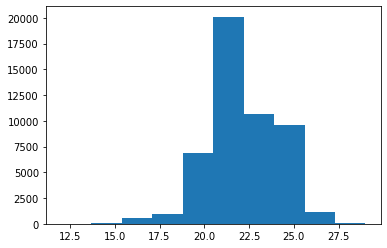

In [110]:
import matplotlib.pyplot as plt

plt.hist(first_place_finishes);

The execution of 50,000 repetitions takes roughly 70 seconds. This can be sped up using multiprocessing, for example.

### Comments, Opinions, & Conclusion

In [ ]:
"""
my notes

created in 2002. now on 4.0.1
 process-interaction
 asynchronous event dispatcher
 uses generator
 create processes, use timeouts to stop processes
 uses other python builtins, such as random, dist generation
 lots of terminology to learn, similar to Arena. 
 can have shared resources that form a queue
 container is cool - (give example of this) doing it manually could get messy
 main functionality seems to be running in parallel after instantiating
 - like arena, can seize delay release, or break out separately. FIFO by default
 - can run until specified end point, or until resources are exhausted
 monitoring/reporting is all "custom"/manual
 
 - simpy.io for animations?
"""